## Introduction 

Below is an example related to my research that I modified from the Dedalus website. The figure demonstrates a Kelvin-Hemholtz instability of a generic tracer, which occurs when there is velocity shear in a continuous fluid.

In [1]:
from IPython.display import Video

Video("KH_Inst.mp4")

## Installation & Required Packages

In [2]:
from dedalus import public as de #public domain
from dedalus.extras import flow_tools #cfd tools needed for fluid mechanics
from dedalus.extras import plot_tools #Plotting
from dedalus.extras.plot_tools import quad_mesh, pad_limits #Mesh capabilites

import logging 
logger = logging.getLogger(__name__) #Log time
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cmocean as cmo

import celluloid #For animations - not necessary for BVPs
from celluloid import Camera #To create the animation
import matplotlib.animation as animation #To Save the animation

## Example problem: Poisson equation (BVP)
### $\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} = sin(x)+cos(y),$
Link - https://bitbucket.org/dedalus-project/dedalus/src/tip/examples/bvp/2d_poisson/poisson.py?at=default.
Note - if you wanted to solve a problem on a domain without a source term, this reduces to Laplace equation. If you are curious about how to solve Laplace or Possion eqn, see https://math.la.asu.edu/~kuiper/502files/Laplace.pdf

### Create bases and domain
You can adjust the number of grid cells to be asymmetrical - which is often the case. This is especially useful if you are solving a problem that has high variability in only one spatial dimension.
Link to general description of spectral methods - https://en.wikipedia.org/wiki/Spectral_method

In [19]:
x_basis = de.Fourier('x', 128, interval=(-2*np.pi, 2*np.pi))
y_basis = de.Chebyshev('y', 128, interval=(-2*np.pi, 2*np.pi))
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

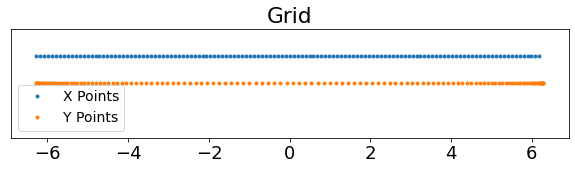

In [20]:
grid_normal = x_basis.grid(scale=1)
grid_normaly = y_basis.grid(scale=1)

plt.figure(figsize=(10, 2))
plt.rcParams.update({'font.size': 18})
plt.plot(grid_normal, np.zeros_like(grid_normal)+1, 'o', markersize=3, label = 'X Points')
plt.plot(grid_normaly, np.zeros_like(grid_normaly+1), 'o', markersize = 3, label = 'Y Points')
plt.ylim([-2, 2])
plt.gca().yaxis.set_ticks([]);
plt.title('Grid')
plt.legend(fontsize = '14')

### Enter equation and BCs
If you are curious about the different types of boundary conditions - https://en.wikipedia.org/wiki/Boundary_value_problem

In [5]:
problem = de.LBVP(domain, variables=['u','uy'])
problem.add_equation("dx(dx(u)) + dy(uy) = sin(x) + cos(y)")
problem.add_equation("uy - dy(u) = 0")

problem.add_bc("left(u) = 0") #It's uncommon for this to be the case but we do this for simplication 
problem.add_bc("right(u) = 0")

### Build solver
Link to documentation if you are curious about types of solvers - https://dedalus-project.readthedocs.io/en/latest/autoapi/dedalus/core/solvers/

In [6]:
solver = problem.build_solver() #Leaving it generic - could specify 
solver.solve()

2020-04-20 14:13:28,882 pencil 0/1 INFO :: Building pencil matrix 1/128 (~1%) Elapsed: 0s, Remaining: 3s, Rate: 5.0e+01/s
2020-04-20 14:13:29,029 pencil 0/1 INFO :: Building pencil matrix 13/128 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 7.7e+01/s
2020-04-20 14:13:29,177 pencil 0/1 INFO :: Building pencil matrix 26/128 (~20%) Elapsed: 0s, Remaining: 1s, Rate: 8.2e+01/s
2020-04-20 14:13:29,322 pencil 0/1 INFO :: Building pencil matrix 39/128 (~30%) Elapsed: 0s, Remaining: 1s, Rate: 8.5e+01/s
2020-04-20 14:13:29,470 pencil 0/1 INFO :: Building pencil matrix 52/128 (~41%) Elapsed: 1s, Remaining: 1s, Rate: 8.5e+01/s
2020-04-20 14:13:29,614 pencil 0/1 INFO :: Building pencil matrix 65/128 (~51%) Elapsed: 1s, Remaining: 1s, Rate: 8.6e+01/s
2020-04-20 14:13:29,756 pencil 0/1 INFO :: Building pencil matrix 78/128 (~61%) Elapsed: 1s, Remaining: 1s, Rate: 8.7e+01/s
2020-04-20 14:13:29,899 pencil 0/1 INFO :: Building pencil matrix 91/128 (~71%) Elapsed: 1s, Remaining: 0s, Rate: 8.8e+01/s
2020-04-20

### Access and plot data

(<matplotlib.axes._axes.Axes at 0x7f5b46c95280>,
 <matplotlib.axes._axes.Axes at 0x7f5b46c416d0>)

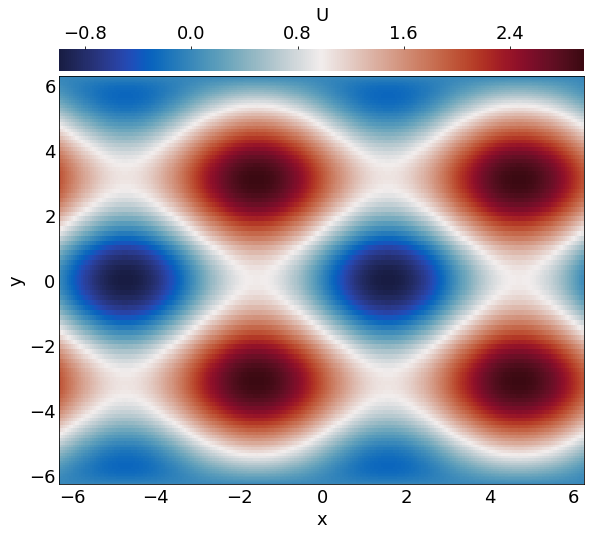

In [7]:
u = solver.state['u']
u.require_grid_space()

fig, ax = plt.subplots(1, figsize = (10, 8))
plot_tools.plot_bot_2d(u, axes = ax, title = 'U', cmap = cmo.cm.balance) #Built in plotting module

# More complicated example - modified Kelvin Hemholtz IVP
### $\frac{\partial u}{\partial t} + u\cdot \nabla u + \frac{\partial p}{\partial x} = \frac{1}{Re} \nabla^2 u$
### $\frac{\partial u}{\partial t} + u\cdot \nabla v + \frac{\partial p}{\partial y} = \frac{1}{Re} \nabla^2 v$
### $\frac{\partial u}{\partial t} + u\cdot \nabla s + \frac{\partial p}{\partial y} = \frac{1}{ReSc} \nabla^2 s$
### $\nabla \cdot u = 0$
Link - https://dedalus-project.readthedocs.io/en/latest/notebooks/KelvinHelmholtzInstability.html

Links about KH problem - https://en.wikipedia.org/wiki/Kelvin%E2%80%93Helmholtz_instability &
http://web.mit.edu/1.63/www/Lec-notes/chap5_instability/5-2KHdiscont.pdf

### Creating bases and domain

In [21]:
#For my animation, I used 526 and 256 grid points and 2000 time steps
x_basis = de.Fourier('x', 100, interval=(0, 2), dealias=3/2) #Dealias to account for nonlinearities
y_basis = de.Chebyshev('y', 50, interval=(-1/2, 1), dealias=3/2)
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

### Enter equation and BCs

In [10]:
Reynolds = 1e6 #Highly turbulent flow
Schmidt = 1

problem = de.IVP(domain, variables=['p','u','v','uy','vy','s','sy'])
problem.meta[:]['y']['dirichlet'] = True
problem.parameters['Re'] = Reynolds
problem.parameters['Sc'] = Schmidt
problem.add_equation("dt(u) + dx(p) - 1/Re*(dx(dx(u)) + dy(uy)) = - u*dx(u) - v*uy")
problem.add_equation("dt(v) + dy(p) - 1/Re*(dx(dx(v)) + dy(vy)) = - u*dx(v) - v*vy")
problem.add_equation("dx(u) + vy = 0")
problem.add_equation("dt(s) - 1/(Re*Sc)*(dx(dx(s)) + dy(sy)) = - u*dx(s) - v*sy")
problem.add_equation("uy - dy(u) = 0")
problem.add_equation("vy - dy(v) = 0")
problem.add_equation("sy - dy(s) = 0")

In [11]:
problem.add_bc("left(u) = 0.5")
problem.add_bc("right(u) = -0.5")
problem.add_bc("left(v) = 0")
problem.add_bc("right(v) = 0", condition="(nx != 0)")
problem.add_bc("left(p) = 0", condition="(nx == 0)")
problem.add_bc("left(s) = 0")
problem.add_bc("right(s) = 1")

### Time-stepping scheme and initial conditions

In [12]:
ts = de.timesteppers.RK443

solver =  problem.build_solver(ts)
solver.stop_sim_time = 5
solver.stop_wall_time = np.inf
solver.stop_iteration = 40

#Initial conditions
initial_dt = 0.2*Lx/nx
cfl = flow_tools.CFL(solver,initial_dt,safety=0.8)
cfl.add_velocities(('u','v'))

x = domain.grid(0)
y = domain.grid(1)
u = solver.state['u']
uy = solver.state['uy']
v = solver.state['v']
vy = solver.state['vy']
s = solver.state['s']
sy = solver.state['sy']

a = 0.05
sigma = 0.2
flow = -0.5
amp = -0.2
u['g'] = flow*np.tanh(y/a)
v['g'] = amp*np.sin(2.0*np.pi*x/Lx)*np.exp(-(y*y)/(sigma*sigma))
s['g'] = 0.5*(1+np.tanh(y/a))
u.differentiate('y',out=uy)
v.differentiate('y',out=vy)
s.differentiate('y',out=sy)

2020-04-20 14:13:48,399 pencil 0/1 INFO :: Building pencil matrix 1/50 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 1.6e+01/s
2020-04-20 14:13:48,569 pencil 0/1 INFO :: Building pencil matrix 5/50 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 2.1e+01/s
2020-04-20 14:13:48,775 pencil 0/1 INFO :: Building pencil matrix 10/50 (~20%) Elapsed: 0s, Remaining: 2s, Rate: 2.3e+01/s
2020-04-20 14:13:48,958 pencil 0/1 INFO :: Building pencil matrix 15/50 (~30%) Elapsed: 1s, Remaining: 1s, Rate: 2.4e+01/s
2020-04-20 14:13:49,135 pencil 0/1 INFO :: Building pencil matrix 20/50 (~40%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s
2020-04-20 14:13:49,330 pencil 0/1 INFO :: Building pencil matrix 25/50 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s
2020-04-20 14:13:49,534 pencil 0/1 INFO :: Building pencil matrix 30/50 (~60%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s
2020-04-20 14:13:49,750 pencil 0/1 INFO :: Building pencil matrix 35/50 (~70%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s
2020-04-20 14:13:49

<Field 140032045708336>

### Write solver loop

In [14]:
s_list = [np.copy(s['g'])] #Only save s since we're interested in the 

logger.info('Starting loop')
start_time = time.time()
while solver.ok:
    dt = cfl.compute_dt()
    solver.step(dt)
    logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
    s_list.append(np.copy(s['g']))

end_time = time.time()

logger.info('Run time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %solver.iteration)

2020-04-20 14:13:52,975 __main__ 0/1 INFO :: Starting loop
2020-04-20 14:13:53,233 __main__ 0/1 INFO :: Iteration: 1, Time: 4.000000e-03, dt: 4.000000e-03
2020-04-20 14:13:53,299 __main__ 0/1 INFO :: Iteration: 2, Time: 8.000000e-03, dt: 4.000000e-03
2020-04-20 14:13:53,529 __main__ 0/1 INFO :: Iteration: 3, Time: 2.688976e-02, dt: 1.888976e-02
2020-04-20 14:13:53,747 __main__ 0/1 INFO :: Iteration: 4, Time: 4.578802e-02, dt: 1.889826e-02
2020-04-20 14:13:53,974 __main__ 0/1 INFO :: Iteration: 5, Time: 6.468317e-02, dt: 1.889515e-02
2020-04-20 14:13:54,212 __main__ 0/1 INFO :: Iteration: 6, Time: 8.356819e-02, dt: 1.888502e-02
2020-04-20 14:13:54,452 __main__ 0/1 INFO :: Iteration: 7, Time: 1.024411e-01, dt: 1.887290e-02
2020-04-20 14:13:54,681 __main__ 0/1 INFO :: Iteration: 8, Time: 1.212999e-01, dt: 1.885885e-02
2020-04-20 14:13:54,884 __main__ 0/1 INFO :: Iteration: 9, Time: 1.401429e-01, dt: 1.884294e-02
2020-04-20 14:13:55,101 __main__ 0/1 INFO :: Iteration: 10, Time: 1.589664e-0

### Change outputs into a numpy array & define plotting grid

In [15]:
s_array = np.array(s_list) #Convert list to array

x_da = domain.grid(0, scales=domain.dealias)
y_da = domain.grid(1, scales=domain.dealias)
xm, ym = np.meshgrid(x_da,y_da) #For plotting

### Make easy animations in Python

2020-04-20 14:17:40,277 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2020-04-20 14:17:40,281 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x500 -pix_fmt rgba -r 5.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpec0ftb98/temp.m4v


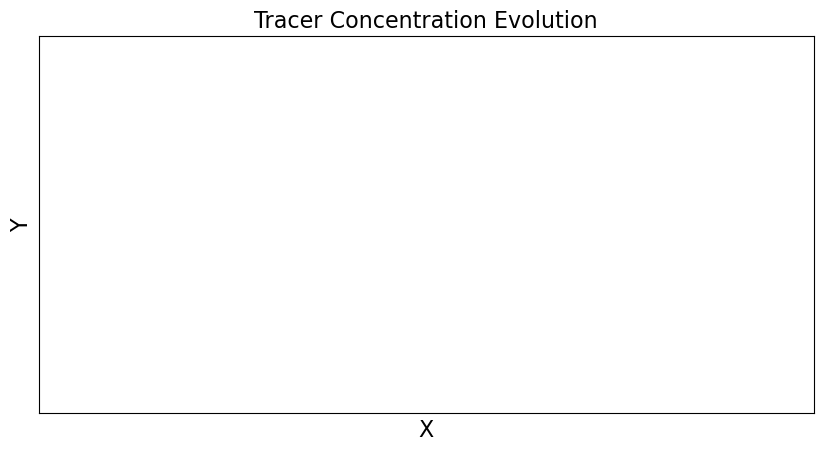

In [18]:
from IPython.display import HTML

fig, ax = plt.subplots(1, figsize = (10, 5), dpi = 100)
camera = Camera(fig)

#Plot at each time step
for i in np.arange(0, len(s_array[:,0,0])):
    im = ax.pcolormesh(xm, ym, s_array[i,:,:].T, cmap = cmo.cm.balance)
    
    ax.set_xlabel('X', fontsize = '16')
    plt.xticks([])
    ax.set_ylabel('Y', fontsize = '16')
    plt.yticks([])
    ax.set_title('Tracer Concentration Evolution', fontsize = 16)
    camera.snap()

ani = camera.animate();
HTML(ani.to_html5_video())

### Summary - BVPs
    1. Define bases and domain
    2. Enter equations and BCs
    3. Select solver - run it

### Summary - IVPs
    1. Define bases and domain
    2. Enter equations, BCs, and ICs
    3. Select solver (timestepping scheme) 
    4. Write solver loop - solve at every timestep